In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
sys.path.append('/home/mei/nas/docker/thesis')
from dataloader.ts_reader import MultiModalDataset, collate_fn
from dataloader.pyg_reader import GraphDataset

from lstm_gnn import PatientOutcomeModel
from lstm_gnn_embedding import PatientOutcomeModelEmbedding

In [3]:
flat_input_dim = 104
graph_input_dim = 104
ts_input_dim = 162
hidden_dim = 128

In [4]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

config = {  
    "data_dir": "/home/mei/nas/docker/thesis/data/hdf",
    "graph_dir": "/home/mei/nas/docker/thesis/data/graphs",
    "mode": "k_closest",
    "k": 3         
}

In [6]:
# === LSTM + Flat Dataset ===
lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train , batch_size=32, shuffle=True, collate_fn=collate_fn)
lstm_loader_val = DataLoader(lstm_dataset_val , batch_size=32, shuffle=False, collate_fn=collate_fn)
lstm_loader_test = DataLoader(lstm_dataset_test , batch_size=32, shuffle=False, collate_fn=collate_fn)

# === Graph Dataset ===

graph_dataset = GraphDataset(config)


==> Loading precomputed graph from /home/mei/nas/docker/thesis/data/graphs/diagnosis_graph_k_closest_k3.pt
==> Loading flat features from /home/mei/nas/docker/thesis/data/hdf/final_flat.h5


In [7]:
def evaluate_model(model, lstm_loader, graph_dataset, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for patient_ids, ts_data, flat_data, risk_data in lstm_loader:
            ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)

            # ** get Graph Embeddings**
            patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)
            outputs,_= model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

            ts_mask = ts_data != -99
            ts_mask = ts_mask.any(dim=2)
            risk_mask = risk_data != -99
            combined_mask = (ts_mask & risk_mask).to(torch.bool)
            
            masked_outputs = outputs[combined_mask]
            masked_risk_data = risk_data[combined_mask]  

            loss = criterion(masked_outputs, masked_risk_data)
            val_loss += loss.item()

    return val_loss / len(lstm_loader)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
model = PatientOutcomeModel(flat_input_dim, graph_input_dim, ts_input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() 

In [9]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [10]:
from torch.amp import GradScaler, autocast
scaler = GradScaler() 

In [ ]:
num_epochs = 10

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for patient_ids, ts_data, flat_data, risk_data in lstm_loader_train:
        ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)

        patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)

        optimizer.zero_grad()
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

            ts_mask = ts_data != -99
            ts_mask = ts_mask.any(dim=2)
            risk_mask = risk_data != -99
            combined_mask = ts_mask & risk_mask

            masked_outputs = outputs[combined_mask]
            masked_risk_data = risk_data[combined_mask]

            loss = criterion(masked_outputs, masked_risk_data)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        torch.cuda.empty_cache()
        gc.collect()

    train_loss /= len(lstm_loader_train)
    train_losses.append(train_loss)

    val_loss = evaluate_model(model, lstm_loader_val, graph_dataset, criterion, device)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [ ]:
# 清理缓存，避免内存碎片化
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
model = PatientOutcomeModelEmbedding(flat_input_dim, graph_input_dim, ts_input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() 

In [12]:
print(next(model.parameters()).device)

cuda:0


In [13]:
current_device = torch.cuda.current_device()

device_name = torch.cuda.get_device_name(current_device)

print(f" {current_device}")
print(f" {device_name}")

 0
 Quadro RTX 6000


In [14]:
num_epochs=10

train_losses = []
val_losses = []

patient_embedding_dict = {} # used to store patient embeddings for each time step
patient_risk_dict = {} # used to store patient risk for each time step


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for patient_ids, ts_data, flat_data, risk_data in lstm_loader_train:
        ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)

        #convert patient_ids to tensor
        patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)

        # forward pass
        optimizer.zero_grad()
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs,_ = model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

            ts_mask = ts_data != -99
            ts_mask = ts_mask.any(dim=2)
            risk_mask = risk_data != -99
            combined_mask = ts_mask & risk_mask

            masked_outputs = outputs[combined_mask]
            masked_risk_data = risk_data[combined_mask]

            loss = criterion(masked_outputs, masked_risk_data)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        torch.cuda.empty_cache()     
        
    train_loss /= len(lstm_loader_train)
    train_losses.append(train_loss)

    # calculate validation loss
    val_loss = evaluate_model(model, lstm_loader_val, graph_dataset, criterion, device)
    val_losses.append(val_loss)
    
    if epoch == num_epochs-1:
        print(" Storing embeddings and risk scores from last epoch...")
        for patient_ids, ts_data, flat_data, risk_data in lstm_loader_train:
            ts_data, flat_data, risk_data = ts_data.to(device), flat_data.to(device), risk_data.to(device)
            patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)

            outputs, embeddings = model(flat_data, graph_dataset.graph_data, patient_ids_tensor, ts_data)

            outputs_np = outputs.detach().cpu().numpy()  # (batch_size, T)
            embeddings_np = embeddings.detach().cpu().numpy()  # (batch_size, T, D_combined)
            patient_ids_np = patient_ids_tensor.detach().cpu().numpy()

            for i, pid in enumerate(patient_ids_np):
                patient_embedding_dict[pid] = embeddings_np[i]  # (T, D_combined)
                patient_risk_dict[pid] = outputs_np[i]  # (T,)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # # save best model
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10, Train Loss: 0.0184, Val Loss: 0.0197
Epoch 2/10, Train Loss: 0.0166, Val Loss: 0.0187
Epoch 3/10, Train Loss: 0.0162, Val Loss: 0.0188
Epoch 4/10, Train Loss: 0.0157, Val Loss: 0.0183
Epoch 5/10, Train Loss: 0.0154, Val Loss: 0.0179
Epoch 6/10, Train Loss: 0.0149, Val Loss: 0.0178
Epoch 7/10, Train Loss: 0.0148, Val Loss: 0.0181
Epoch 8/10, Train Loss: 0.0153, Val Loss: 0.0193
Epoch 9/10, Train Loss: 0.0167, Val Loss: 0.0201
 Storing embeddings and risk scores from last epoch...
Epoch 10/10, Train Loss: 0.0187, Val Loss: 0.0218


In [15]:
import pickle
import os

save_dir = '/home/mei/nas/docker/thesis/data/model_results' 
os.makedirs(save_dir, exist_ok=True)

# save patient_embedding_dict
embedding_path = os.path.join(save_dir, 'patient_embedding_dict.pkl')
with open(embedding_path, 'wb') as f:
    pickle.dump(patient_embedding_dict, f)

# save patient_risk_dict
risk_path = os.path.join(save_dir, 'patient_risk_dict.pkl')
with open(risk_path, 'wb') as f:
    pickle.dump(patient_risk_dict, f)


In [ ]:

save_dir = '/home/mei/nas/docker/thesis/data/model_results' 

# load patient_embedding_dict
embedding_path = os.path.join(save_dir, 'patient_embedding_dict.pkl')
with open(embedding_path, 'rb') as f:
    patient_embedding_dict = pickle.load(f)

# load patient_risk_dict
risk_path = os.path.join(save_dir, 'patient_risk_dict.pkl')
with open(risk_path, 'rb') as f:
    patient_risk_dict = pickle.load(f)


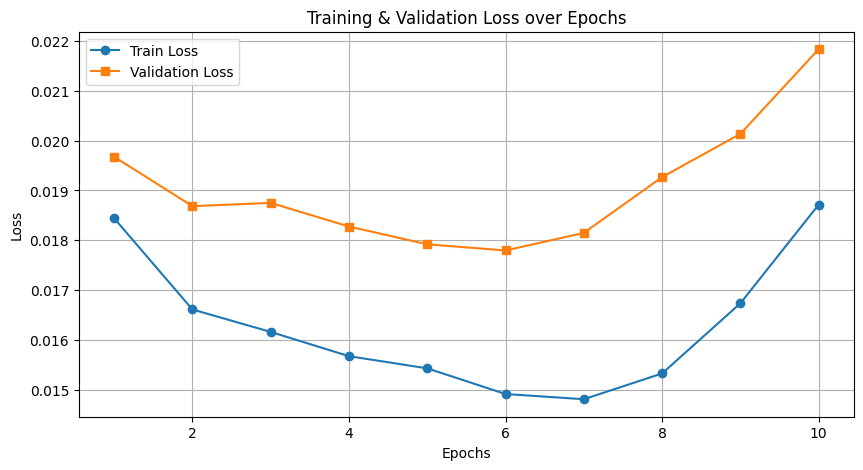

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

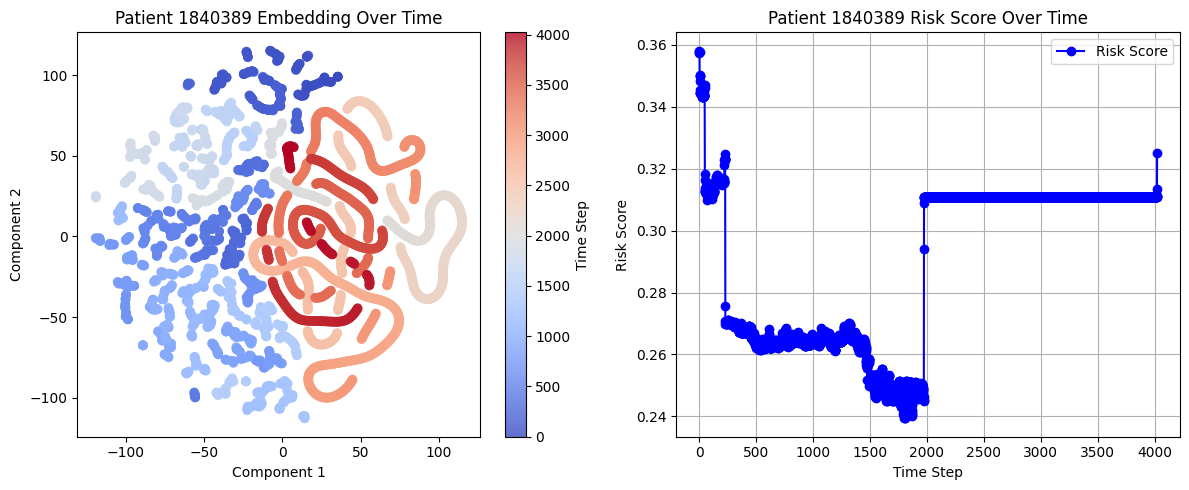

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


selected_patient_id = 1840389

# get risk and  embedding (T, D_combined)
selected_embedding = patient_embedding_dict[selected_patient_id]
selected_risk_score = patient_risk_dict[selected_patient_id]

# dimensionality reduction method
use_tsne = True  # set to False to use PCA
if use_tsne:
    reducer = TSNE(n_components=2, perplexity=5, random_state=42)
else:
    reducer = PCA(n_components=2)

# dimensionality reduction
embedding_2d = reducer.fit_transform(selected_embedding)  # (T, 2)

# plot risk and embedding over time
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1 Embedding
scatter = ax[0].scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=range(selected_embedding.shape[0]), cmap="coolwarm", alpha=0.8)
ax[0].set_title(f"Patient {selected_patient_id} Embedding Over Time")
ax[0].set_xlabel("Component 1")
ax[0].set_ylabel("Component 2")
fig.colorbar(scatter, ax=ax[0], label="Time Step")

# 2 Risk Score 
ax[1].plot(range(len(selected_risk_score)), selected_risk_score, marker='o', linestyle='-', color='b', label="Risk Score")
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Risk Score")
ax[1].set_title(f"Patient {selected_patient_id} Risk Score Over Time")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


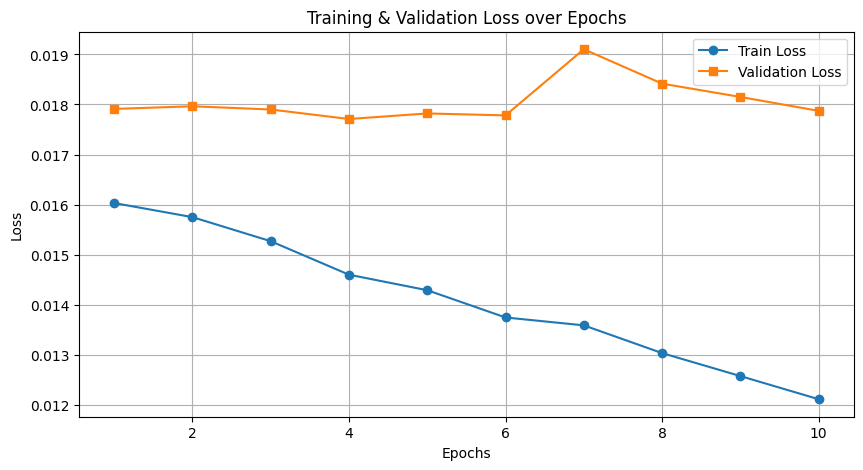

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()